In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('spam.csv',encoding='latin-1')
df = df.dropna(how = "any", axis = 1)
df.columns = ['v1','v2']
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df['Spam']=pd.get_dummies(df['v1'], drop_first=True)
df=df.drop('v1', axis=1)
df.head()

,v2,Spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


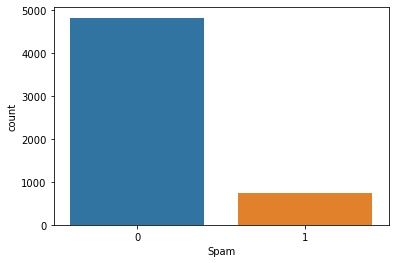

In [5]:
sns.countplot(x = 'Spam', data = df)
plt.show()

In [6]:
import re
import string
from string import punctuation
from nltk.corpus import stopwords
def text_processing(message):
    
    Stopwords = stopwords.words('english')
    # Check characters to see if they are in punctuation
    no_punctuation = [char for char in message if char not in string.punctuation]# Join the characters again to form the string
    no_punctuation = ''.join(no_punctuation)
    
    # Now just remove any stopwords
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in Stopwords])
df['text'] = df['v2'].apply(text_processing)
df.head()

,v2,Spam,text
0,"Go until jurong point, crazy.. Available only ...",0,Go jurong point crazy Available bugis n great ...
1,Ok lar... Joking wif u oni...,0,Ok lar Joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,U dun say so early hor... U c already then say...,0,U dun say early hor U c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,Nah dont think goes usf lives around though


In [7]:
from sklearn.model_selection import train_test_split
X=df['text'].values
y=df['Spam'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
#Vectorization
bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train=X_train.toarray()
X_test=X_test.toarray()

In [9]:
X_train.shape

(4457, 8270)

In [10]:
import tensorflow as tf
from tensorflow.keras import Input,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

def create_model(input_shape):
    input = Input(shape = input_shape)
    x = Dense(units=8270,activation='relu')(input)
    x = Dropout(0.5)(x)
    x = Dense(units=400, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=1,activation = 'sigmoid')(x)
    model=Model(input,x)
    return model
model = create_model(8270)

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model.compile(loss='binary_crossentropy', optimizer='adam',metrics = METRICS)
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X_train,y=y_train,epochs=4,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])

Epoch 1/4
140/140 [==============================] - 35s 242ms/step - loss: 0.1673 - tp: 342.0000 - fp: 38.0000 - tn: 3822.0000 - fn: 255.0000 - accuracy: 0.9343 - precision: 0.9000 - recall: 0.5729 - auc: 0.9529 - prc: 0.8453 - val_loss: 0.0768 - val_tp: 136.0000 - val_fp: 8.0000 - val_tn: 957.0000 - val_fn: 14.0000 - val_accuracy: 0.9803 - val_precision: 0.9444 - val_recall: 0.9067 - val_auc: 0.9829 - val_prc: 0.9635
Epoch 2/4
140/140 [==============================] - 33s 237ms/step - loss: 0.0231 - tp: 573.0000 - fp: 11.0000 - tn: 3849.0000 - fn: 24.0000 - accuracy: 0.9921 - precision: 0.9812 - recall: 0.9598 - auc: 0.9974 - prc: 0.9921 - val_loss: 0.0836 - val_tp: 133.0000 - val_fp: 6.0000 - val_tn: 959.0000 - val_fn: 17.0000 - val_accuracy: 0.9794 - val_precision: 0.9568 - val_recall: 0.8867 - val_auc: 0.9761 - val_prc: 0.9603
Epoch 3/4
140/140 [==============================] - 33s 235ms/step - loss: 0.0041 - tp: 594.0000 - fp: 1.0000 - tn: 3859.0000 - fn: 3.0000 - accuracy: 0.9

(0.0, 0.5)

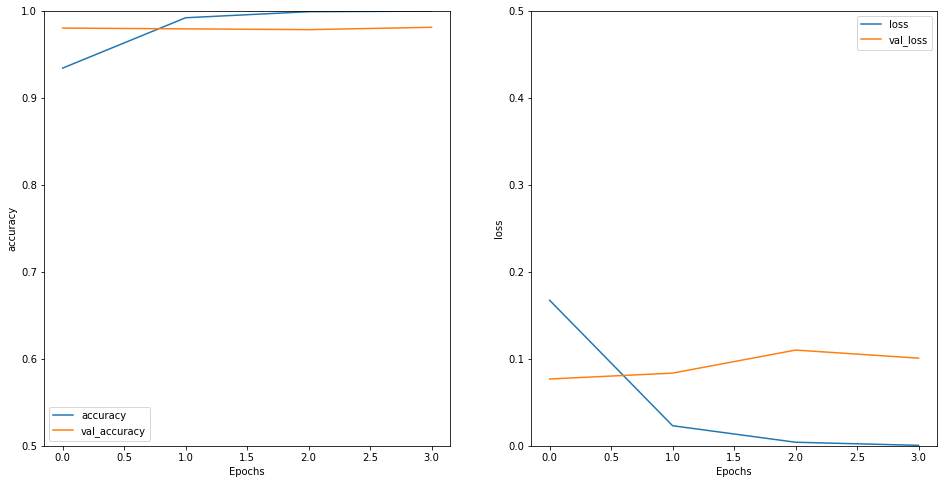

In [12]:

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0.5, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, 0.5)

In [13]:
prediction=model.predict(X_test)
predictions = []
for p in prediction:
    if p<=0.5:
        predictions.append(0)
    else:
        predictions.append(1)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[961   4]
 [ 17 133]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.97      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

